# Benchmark model - Impairment - Sequential Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-04-30_imp_bg_'
valid_code = '_val_12000_3000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190812_1612'
postfix_time_seq = '_190812_1547'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_imp"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [3]:
#recombining folds for grid search

val_X_all = []
val_y_all = []

count=0
for idx in indexes:
    val_X_all.append(val_X_train[idx[0]])
    val_y_all.append(val_y_train[idx[0]])
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_all.append(val_X_test[test_idx])
    val_y_all.append(val_y_test[test_idx])
    count+=1
        

In [4]:
val_X_all = np.concatenate(val_X_all, axis=0)
val_y_all = np.concatenate(val_y_all, axis=0)

In [6]:
val_X_all.shape

(166101, 35)

In [7]:
val_X_all_df = pd.DataFrame(val_X_all, columns=feature_labels)
val_X_all_df.head()

,currency_Schweizer Franken,currency_Euro,currency_US-Dollar,currency_Britisches Pfund,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,...,flow_shock_p90,p90_c_node_eff,p90_energy,p90_d_node_flow,flow_shock_p180,p180_d_node_flow,p180_energy,invoice_amount,purchase_amount,invoice_date
0,0.405882,-0.39407,-0.030279,-0.078383,-2.338041,0.106013,-0.627951,-0.459644,-0.160418,-0.10242,...,-0.152564,-0.409205,-0.539282,-0.156223,-0.540686,-0.155163,-0.539163,-0.697699,-2.261077,-4.029658
1,0.405882,-0.39407,-0.030279,-0.078383,-2.338041,0.106013,-0.617918,-0.459644,-0.160418,-0.10242,...,-0.152564,-0.409205,-0.539282,-0.156223,-0.540686,-0.155163,-0.539163,-0.093803,-2.261077,-4.029658
2,0.405882,-0.39407,-0.030279,-0.078383,-2.338041,0.106013,-0.607886,-0.459644,-0.160418,-0.10242,...,-0.152564,-0.409205,-0.539282,-0.156223,-0.540686,-0.155163,-0.539163,-0.423771,-2.261077,-4.029658
3,0.405882,-0.39407,-0.030279,-0.078383,-2.338041,0.106013,-0.627951,-0.459644,-0.160418,-0.10242,...,6.554623,-0.409909,4.526143,-0.156223,4.502119,-0.155163,4.526060,0.862325,-2.261077,-4.029658
4,0.405882,-0.39407,-0.030279,-0.078383,-2.338041,0.106013,-0.627951,-0.459644,-0.160418,-0.10242,...,6.554623,-0.409909,4.526143,-0.156223,4.502119,-0.155163,4.526060,0.393567,-2.261077,-4.029658


In [9]:
val_X_all_df.columns

Index(['currency_Schweizer Franken', 'currency_Euro', 'currency_US-Dollar',
       'currency_Britisches Pfund', 'has_purchase', 'dd_value_date',
       'cd_lent_c', 'cd_repaid_c', 'cd_impaired1_c', 'cd_pastdue90_c',
       'cd_trend_a', 'c_lent_c', 'c_repaid_c', 'c_impaired1_c',
       'c_pastdue90_c', 'c_trend_a', 'd_repaid_c', 'd_impaired1_c',
       'd_pastdue90_c', 'd_trend_a', 'd_we_payment_share', 'flow_shock_imp1',
       'imp_c_node_eff', 'imp_energy', 'imp_d_node_flow', 'flow_shock_p90',
       'p90_c_node_eff', 'p90_energy', 'p90_d_node_flow', 'flow_shock_p180',
       'p180_d_node_flow', 'p180_energy', 'invoice_amount', 'purchase_amount',
       'invoice_date'],
      dtype='object')

In [10]:
val_X_all_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_Schweizer Franken,166101.0,-0.039094,1.039196,-4.284255,0.262033,0.469050,0.476570,0.481698
currency_Euro,166101.0,0.040913,1.043195,-0.470240,-0.464681,-0.454573,-0.247188,4.602298
currency_US-Dollar,166101.0,0.004695,1.096866,-0.094852,-0.075491,-0.060664,-0.060664,33.026505
currency_Britisches Pfund,166101.0,-0.002616,0.939837,-0.078383,-0.073798,-0.073798,-0.039823,36.501141
has_purchase,166101.0,0.021908,0.980263,-2.811063,0.355737,0.403892,0.427708,0.480516
dd_value_date,166101.0,-0.039273,0.936437,-0.380763,-0.194282,-0.099123,-0.012911,109.539948
cd_lent_c,166101.0,0.072556,1.089725,-0.704269,-0.569290,-0.424353,0.138343,4.503405
cd_repaid_c,166101.0,0.066349,1.086067,-0.662002,-0.459644,-0.395134,-0.026816,4.865366
cd_impaired1_c,166101.0,0.008288,1.011031,-0.233639,-0.177975,-0.165605,-0.165605,9.950925
cd_pastdue90_c,166101.0,0.032430,1.162178,-0.284198,-0.102420,-0.024159,-0.020417,48.979588


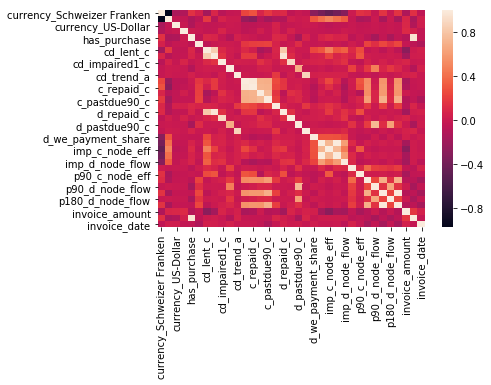

In [11]:
sns.heatmap(val_X_all_df.corr())

### SGD Classifier

In [12]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 13101 from index 0 to 13100, test on 3000 from 0 to 2999
Fold 1 AUC: 0.4836247414927618
Fold 2: train  on 12000 from index 4101 to 16100, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.4860205582339108
Fold 3: train  on 12000 from index 7101 to 19100, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5376261768791479
Fold 4: train  on 12000 from index 10101 to 22100, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6016965898825655
Fold 5: train  on 12000 from index 13101 to 25100, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.7184232377906261
Fold 6: train  on 12000 from index 16101 to 28100, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.5430479251535423
Fold 7: train  on 12000 from index 19101 to 31100, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.6122562936980439
Fold 8: train  on 12000 from index 22101 to 34100, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.6812490628280102
Fold 9: train  on 12000 from index 25101 to 37100, test on 3000 from 24000 to 26999
Fold 9 AUC: 

In [13]:
sgd_clf.fit(X_train, y_train)
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[10996    37]
 [  412    73]]
Confusion matrix: 
[[0.99665 0.00335]
 [0.03734 0.00662]]
AUC 0.780


In [23]:
#save_sk_model(sgd_clf, "../data/models/", 'sgd', 'benchmark')

In [15]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [100, 180, 200, 250, 300, 320, 350] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(val_X_all.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(val_X_all, val_y_all)

Preparing fold 0 with 13101 train observations and 3000 test observations, starti=4101...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=7101...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=10101...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=13101...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=16101...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=19101...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=22101...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=25101...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=28101...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=31101...
Preparing fold 10 with 12000 train observations and 3000 test observations, starti=34101...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    2.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   15.6s
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:   44.7s
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:   52.1s
[Parallel(n_jobs=7)]: Done 1257 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 2147 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 2711 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done 3318 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 4055 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 5593 tasks      | elapsed:  4.1min
[Parallel(n_jobs=7)]: Done 7295 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 9157 tasks      | elapsed:  5.7min
[Parallel(n_jobs=7)]: Done 11183 tasks      | elapsed:  6.4min
[Parallel(n_jobs=7)]: Done 12839 out of 12852 | elapsed:  7.4min remaining:    0.3s
[Parallel(n_jobs=7)]: Done 12852 out o

GridSearchCV(cv=<generator object rolling_window at 0x00000197EB941A40>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5...
                                     verbose=0, warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
                         'max_iter': [100, 180, 200, 250, 300, 320, 3

In [16]:
sgd_gsearch.best_params_

{'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'log', 'max_iter': 250}

In [17]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=250, loss='log', learning_rate='adaptive', eta0=0.01, tol=0.0001) 
sgd_gs_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 13101 from index 0 to 13100, test on 3000 from 0 to 2999
Fold 1 AUC: 0.4836247414927618
Fold 2: train  on 12000 from index 4101 to 16100, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.4860205582339108
Fold 3: train  on 12000 from index 7101 to 19100, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5376261768791479
Fold 4: train  on 12000 from index 10101 to 22100, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6016965898825655
Fold 5: train  on 12000 from index 13101 to 25100, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.7184232377906261
Fold 6: train  on 12000 from index 16101 to 28100, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.5430479251535423
Fold 7: train  on 12000 from index 19101 to 31100, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.6122562936980439
Fold 8: train  on 12000 from index 22101 to 34100, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.6812490628280102
Fold 9: train  on 12000 from index 25101 to 37100, test on 3000 from 24000 to 26999
Fold 9 AUC: 

In [18]:
sgd_gs.fit(X_train, y_train)
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[10998    35]
 [  423    62]]
Confusion matrix: 
[[0.99683 0.00317]
 [0.03834 0.00562]]
AUC 0.783


### Random Forest Classifier

In [20]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf_diag = model_diag_seq(rf_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 13101 from index 0 to 13100, test on 3000 from 0 to 2999
Fold 1 AUC: 0.908734724572288
Fold 2: train  on 12000 from index 4101 to 16100, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.7906072307728607
Fold 3: train  on 12000 from index 7101 to 19100, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5623367803673406
Fold 4: train  on 12000 from index 10101 to 22100, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.7062196533423668
Fold 5: train  on 12000 from index 13101 to 25100, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.8569012178619756
Fold 6: train  on 12000 from index 16101 to 28100, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.8455419765544219
Fold 7: train  on 12000 from index 19101 to 31100, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.8358762416339628
Fold 8: train  on 12000 from index 22101 to 34100, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.903902384165542
Fold 9: train  on 12000 from index 25101 to 37100, test on 3000 from 24000 to 26999
Fold 9 AUC: 0.

In [21]:
rf_clf.fit(X_train, y_train)
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[10123   910]
 [   94   391]]
Confusion matrix: 
[[0.91752 0.08248]
 [0.00852 0.03544]]
AUC 0.954


### Randomized Grid Search

In [22]:
# Number of trees in random forest
n_estimators = [150, 180, 200, 250, 280, 300, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 10, 20]
# Maximum number of levels in tree
max_depth = [100,200, None]
#Max leaf nodes
max_leaf_nodes = [10,20,40,60]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [23]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, 
                               cv = rolling_window(X_train.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True), 
                               verbose=2, random_state=42, n_jobs =7, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(val_X_all, val_y_all)

Preparing fold 0 with 13101 train observations and 3000 test observations, starti=4101...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=7101...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=10101...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=13101...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=16101...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=19101...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=22101...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=25101...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=28101...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=31101...
Preparing fold 10 with 12000 train observations and 3000 test observations, starti=34101...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   27.6s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:  8.7min
[Parallel(n_jobs=7)]: Done 880 out of 880 | elapsed: 13.1min finished


RandomizedSearchCV(cv=<generator object rolling_window at 0x00000197EB82CDB0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fracti...
                   param_distributions={'bootstrap': [True, False],
    

In [24]:
rf_random.best_params_

{'n_estimators': 280,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 60,
 'max_features': 20,
 'max_depth': 200,
 'bootstrap': True}

In [25]:
# Number of trees in random forest
n_estimators = [250, 280, 300] 
# Number of features to consider at every split
max_features = ['auto', 20]
# Maximum number of levels in tree
max_depth = [None, 200]
#Max leaf nodes
max_leaf_nodes = [60,80]
# Minimum number of samples required to split a node
min_samples_split = [10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [27]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = rolling_window(val_X_all.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(val_X_all, val_y_all)

Preparing fold 0 with 13101 train observations and 3000 test observations, starti=4101...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=7101...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=10101...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=13101...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=16101...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=19101...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=22101...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=25101...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=28101...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=31101...
Preparing fold 10 with 12000 train observations and 3000 test observations, starti=34101...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   17.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  4.9min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed: 15.9min
[Parallel(n_jobs=7)]: Done 999 tasks      | elapsed: 22.2min
[Parallel(n_jobs=7)]: Done 1224 out of 1224 | elapsed: 32.1min finished


GridSearchCV(cv=<generator object rolling_window at 0x00000197EB9E38E0>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_lea...
                                              warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'bootstrap': [True], 'max_depth': [None, 200],
                         'max_features': ['auto', 20],
         

In [28]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 200,
 'max_features': 'auto',
 'max_leaf_nodes': 80,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 250}

In [29]:
#optimized params 
rf_opt = {'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 80,
 'max_features': 'auto',
 'max_depth': 200,
 'bootstrap': True}

In [31]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)

rf_opt_diag = model_diag_seq(rf_opt_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 13101 from index 0 to 13100, test on 3000 from 0 to 2999
Fold 1 AUC: 0.9196691107351006
Fold 2: train  on 12000 from index 4101 to 16100, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.8146180525516905
Fold 3: train  on 12000 from index 7101 to 19100, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5051118999845655
Fold 4: train  on 12000 from index 10101 to 22100, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.5878429878048781
Fold 5: train  on 12000 from index 13101 to 25100, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.8264777340386271
Fold 6: train  on 12000 from index 16101 to 28100, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.8083679037261278
Fold 7: train  on 12000 from index 19101 to 31100, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.8519476842494358
Fold 8: train  on 12000 from index 22101 to 34100, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.8772023541760383
Fold 9: train  on 12000 from index 25101 to 37100, test on 3000 from 24000 to 26999
Fold 9 AUC: 

In [32]:
rf_opt_clf.fit(X_train, y_train)
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[11033     0]
 [  461    24]]
Confusion matrix: 
[[1.      0.     ]
 [0.04178 0.00218]]
AUC 0.961
